# Filling the gaps

*A practical guide for interpolation methods, from linear interpolation to machine learning, applied to engineering problems in Python.*

Engineering simulations must often be performed using incomplete data from various sources, for example when running power system studies with generator limits defined by a few data points in a table. In an ideal world, the manufacturers would always share well defined, complete and accurate simulation models of their equipment. In reality, and this is especially true early in the project, the data is often severely lacking and is thus not sufficient for use in power system studies.

Interpolation techniques, such as linear, polynomial, nearest neighbor and gradient boosting regression, are useful methods engineers can easily include and combine into their calculations and studies to compensate for such gaps.

## An example in renewable energy

An interesting example comes from reactive power capability of wind turbine generators; the maximum reactive power output of a wind turbine (capacitive or inductive) generally depends on both the active power it is currently generating, and the voltage at its terminal. Power system studies are often performed at a few fixed values of active power (ex.: Maximum and minimum active power), but a windfarm design optimization process sometimes requires the simulation of operation at various other values of active power (this heavily depends on local utility requirements).

The voltage at each wind turbine also varies significantly depending on how they are interconnected; the voltage at the turbine depends on the impedance on the collection system between itself and the substation's collector bus, the wind turbine's generation (active and reactive power), fixed or variable voltage transformation or regulation (ex.: a wind turbine transformer with its deenergized tap changer, an autotransformer voltage regulator, etc.), and the influence of other wind turbines and components on the collector.

See [this article](https://www.esig.energy/wiki-main-page/reactive-power-capability-and-interconnection-requirements-for-pv-and-wind-plants/) for more details on reactive power capability and interconnection requirements for PV and wind plants.

> No data in this article comes from real applications or manufacturer data; hypothetical data is used to present interesting interpolation opportunities.

We'll start by importing a few librairies and defining our data for the following examples. I use [pandas](https://pandas.pydata.org/) as much as possible; anytime I can put my data in tabular form. It's an immensely powerful and pratical library that is unfortunately not especially intuitive - at least in my opinion - hence using it whenever I can helps remain confortable with it. I would recommend the [Move from Excel to Python with Pandas](https://training.talkpython.fm/courses/move-from-excel-to-python-and-pandas) course from [Talk Python Training](https://training.talkpython.fm/) for anyone looking into getting confortable with `pandas`.

In [1]:
import pandas as pd

> When preparing an engineering deliverable with a [Jupyter Notebook](https://jupyter.org/), I like to [hide code cells](https://data-dive.com/jupyterlab-markdown-cells-include-variables/) (the input) and only show their output. Instead of showing the input code, I replace it with [LaTeX](https://www.latex-project.org/) formula and [Markdown](https://en.wikipedia.org/wiki/Markdown) explaination.

In [2]:
columns = (
    "P (pu)",  # Active power
    0.90,      # Voltage (pu)
    0.95,      # Voltage (pu)
    1.00,      # Voltage (pu)
    1.05,      # Voltage (pu)
    1.10,      # Voltage (pu)
)
qcap_max = pd.DataFrame(columns=columns)

In [3]:
values = {
    "P (pu)": 1.00,
    0.90: 1.00,  # MVAR (capacitive),
    0.95: 1.00,  # MVAR (capacitive),
    1.00: 2.20,  # MVAR (capacitive),
    1.05: 3.00,  # MVAR (capacitive),
    1.10: 2.50,  # MVAR (capacitive),
}
qcap_max = pd.concat([qcap_max, pd.DataFrame(values, index=[0])])

In [4]:
values = {
    "P (pu)": 0.95,
    0.90: 1.00,  # MVAR (capacitive),
    0.95: 2.00,  # MVAR (capacitive),
    1.00: 3.00,  # MVAR (capacitive),
    1.05: 3.00,  # MVAR (capacitive),
    1.10: 3.00,  # MVAR (capacitive),
}
qcap_max = pd.concat([qcap_max, pd.DataFrame(values, index=[0])])

In [5]:
values = {
    "P (pu)": 0.90,
    0.90: 1.50,  # MVAR (capacitive),
    0.95: 2.50,  # MVAR (capacitive),
    1.00: 3.00,  # MVAR (capacitive),
    1.05: 3.00,  # MVAR (capacitive),
    1.10: 3.00,  # MVAR (capacitive),
}
qcap_max = pd.concat([qcap_max, pd.DataFrame(values, index=[0])])

In [6]:
qcap_max.set_index("P (pu)", inplace=True)

In the following table (`qcap_max`), the index is the active power (in pu), the headers are the wind turbine voltages (in pu), and the values are the maximum capacitive reactive power output in these conditions (in MVAR):

In [7]:
qcap_max

,0.9,0.95,1.0,1.05,1.1
P (pu),,,,,
1.00,1.0,1.0,2.2,3.0,2.5
0.95,1.0,2.0,3.0,3.0,3.0
0.90,1.5,2.5,3.0,3.0,3.0


> It's not an adequate presentation for an engineering deliverable, but it will serve the following examples just fine.

[Matplotlib](https://matplotlib.org/) is used to plot the 2D data:

In [8]:
import matplotlib.pyplot as plt

The first figure presents the first line of data, i.e.: the maximum capacitive reactive power output at full active power, from 0.90 pu to 1.10 pu voltage:

In [9]:
qcap_max_fullpower = qcap_max.loc[1, :]

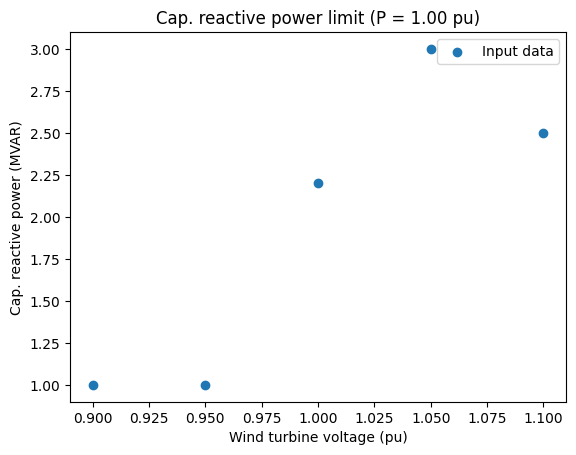

In [10]:
plt.scatter(
    qcap_max_fullpower.index,
    qcap_max_fullpower.values,
    label="Input data",
)

plt.title("Cap. reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine voltage (pu)")
plt.ylabel("Cap. reactive power (MVAR)")
plt.legend()
plt.show()

This may be sufficient for simplified calculations, but the wind turbines will *not* all be at the same voltage during operation, even if they are all at full active power. What would then be their reactive power limit at 1.047 pu voltage? 1.051 pu? Etc.? This is not enough to run a power flow study; intermediate points must be available.

Interestingly, simply using the [plot method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) on a `pandas` DataFrame or Series will generate a line graph of the data *with linear interpolation* between each point (a scatter plot can be specified, but it can only be used on DataFrames; not on Series).

> Note the semicolon at the end of the last line; without it, the following text appears between the code and the figure: `<Axes: title={'center': 'Capacitive reactive power limit (P = 1.00 pu)'}, xlabel='Wind turbine voltage (pu)', ylabel='Capacitive reactive power (MVAR)'>`

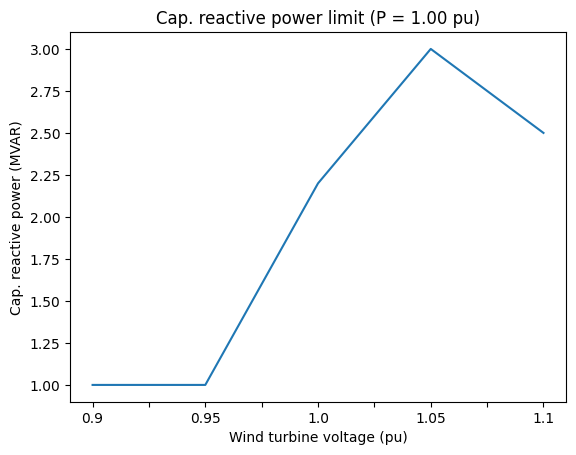

In [11]:
qcap_max_fullpower.plot(
    title="Cap. reactive power limit (P = 1.00 pu)",
    xlabel="Wind turbine voltage (pu)",
    ylabel="Cap. reactive power (MVAR)",
);

While this figure is interesting, it doesn't allow us to dynamically predict reactive power limits during execution; a prediction function is required.

## Linear interpolation

Linear interpolation is the mathematical equivalent of "connect the dots"; a straight line is drawn between each data point. It's simple, straighforward, but crude and sometimes unrealistic. Technical judgement is critical to select the best interpolation method to apply to specific problems, and the consequences of the errors in predictions must be understood.

In [12]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from more_itertools import pairwise
from typing import List

The following function `linear_interpolation` takes 2 lists (x and y) and returns a list of predictions between each pair of points or dots in the input data. The `zip()` function aggregates both lists into a list of tuples of (x, y) (see [here](https://docs.python.org/dev/library/functions.html#zip) for some examples and details), and `pairwise()` returns the list in overlapping pairs (collections of 2 points, see [here](https://docs.python.org/dev/library/itertools.html#itertools.pairwise)).

In [13]:
def linear_interpolation(x: List[float], y: List[float]) -> List[tuple]:
    z = zip(x, y)
    f = []
    
    for z1, z2 in pairwise(z):
        func = Polynomial.fit((z1[0], z2[0]), (z1[1], z2[1]), deg=1)
        f.append(((z1[0], z2[0]), func))

    return f  # List of [(x_start, x_stop, predictor), ...]

Since the prediction model is different between each data point, the following function `qcap_max_fullpower_linear()` is used to return the prediction using the correct model depending on the input data `x` (the wind turbine voltage in pu, in our example):

In [14]:
def qcap_max_fullpower_linear(x: float) -> float:
    q = qcap_max_fullpower
    for z in linear_interpolation(q.index, q.values):
        if z[0][0] <= x <= z[0][1]:
            return z[1](x)

To plot the results, 50 data points are generated betwen en 0.90 pu and 1.10 pu and a prediction is made for each one by calling `qcap_max_fullpower_linear()`:

In [15]:
x = np.linspace(0.90, 1.10, 100)

In [16]:
y = [qcap_max_fullpower_linear(i) for i in x]

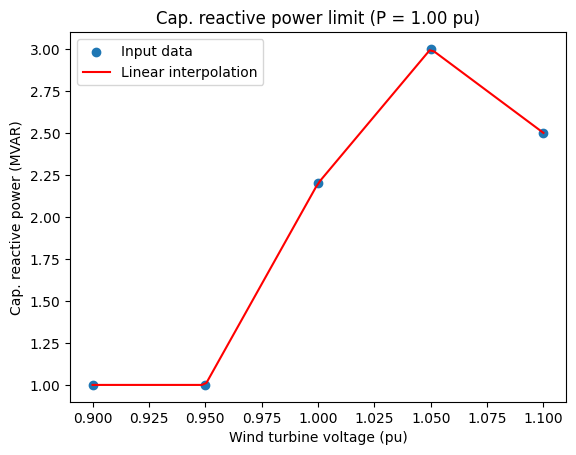

In [17]:
plt.scatter(
    qcap_max_fullpower.index,
    qcap_max_fullpower.values,
    label="Input data",
)
plt.plot(x, y, color="r", label="Linear interpolation")

plt.title("Cap. reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine voltage (pu)")
plt.ylabel("Cap. reactive power (MVAR)")
plt.legend()
plt.show()

The prediction function can be used for any value between its limits, for example:

In [18]:
# Voltage (pu)
v = 1.023

# Maximum capacitive reactive power (MVAR)
q = qcap_max_fullpower_linear(v)  

print(f"Max. cap. reactive power at full active \
power and a voltage of {v:.3f} pu: {q:.3f} MVAR")

Max. cap. reactive power at full active power and a voltage of 1.023 pu: 2.568 MVAR


The key issue with this interpolation method for this particular example is that it makes the reactive power limit excessively dependant on voltage around 1.05 pu; a slight increase or decrease in voltage significantly reduces the expected reactive power limit. Based on relevant experiences, I would expect the output around 1.05 pu voltage to be either parabolic, or with a relatively narrow, straight line at 3.00 MVAR.

The parabolic shape can be obtained with polynomial interpolation, and the straight line with nearest neighbor interpolation.

## Polynomial interpolation

Polynomial interpolation is fun, but swingy. It basically produces an equation of $n$ number of polynomials which are tuned to match the input data. $n$ is the *degree* of the interpolation; a number too low will produce poorly matched results, but one too high will oscillate. You most likely wnat the lowest number that produce sensible results.

We don't need to break the input data into pairs as in the linear interpolation; the polynomial variant takes the whole input into consideration. It is thus a lot more straightforward to implement:

In [19]:
from numpy.polynomial.polynomial import Polynomial

Since I have chosen to use the Pandas DataFrame's headers as data, they need to be converted to float before being used by the polynomial fit:

In [20]:
x_values = qcap_max_fullpower.index.astype("float64")
y_values = qcap_max_fullpower.values

It's good practice to try different degrees and choose the best one for each problem. In the following figure, a degree of 4 is clearly the best fit; the overshoot after 1.05 pu voltage is minor and it fits the input data nicely.

/home/michel/.local/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


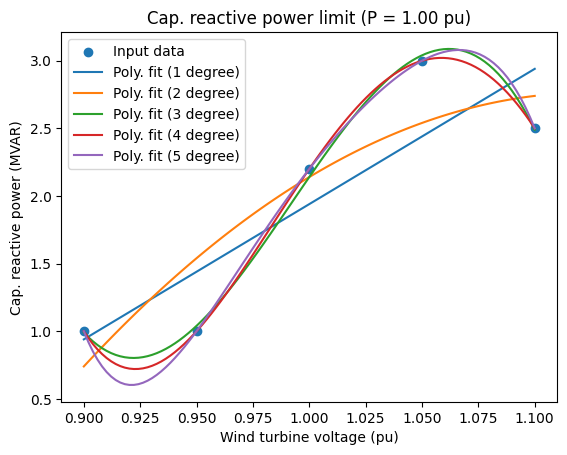

In [21]:
plt.scatter(x_values, y_values, label="Input data")

for degree in range(1, 6):

    polynomial_fit = Polynomial.fit(x_values, y_values, deg=degree)
    plt.plot(x, polynomial_fit(x), label=f"Poly. fit ({degree} degree)")

plt.title("Cap. reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine voltage (pu)")
plt.ylabel("Cap. reactive power (MVAR)")
plt.legend()
plt.show();

The issue though is that the fit between 0.900 pu and 0.950 pu makes no technical sense; the maximum capacitive reactive power output in that range should be flat, at 1.0 MVAR. A polynomial interpolation can't produce the expected behavior by itself; it must be combined with another method.

### Combining linear and polynomial fit

A simple way to get our flat prediction between 0.900 pu and 0.950 pu voltage is to combine a linear interpolation in this region with a polynomial interpolation elsewhere. Notice that the degree was reduced to 3 for the polynomial fit; removing the first data point made this fit simpler and thus adequate for this degree.

In [22]:
linear_fit = Polynomial.fit(x_values[:2], y_values[:2], deg=1)

degree = 3
polynomial_fit = Polynomial.fit(x_values[1:], y_values[1:], deg=degree)

The `combined_fit()` function contains a [list comprehension](https://docs.python.org/dev/tutorial/datastructures.html#list-comprehensions), which more concise and arguably more readable than the equivalent standard for loop: 

In [23]:
def combined_fit(x: List[float]) -> List[float]:
    return [linear_fit(i) if i <= 0.95 else polynomial_fit(i) for i in x]

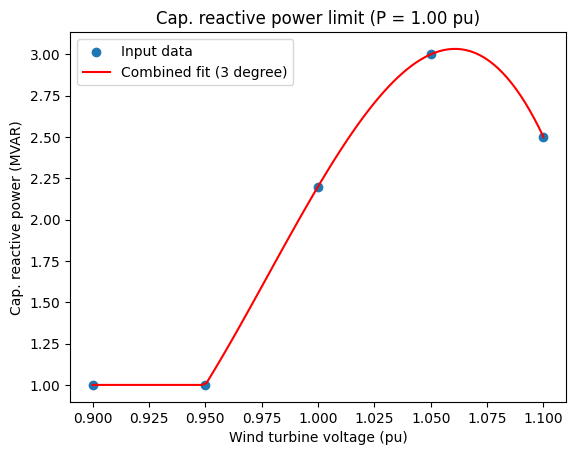

In [24]:
plt.scatter(x_values, y_values, label="Input data")
plt.plot(x, combined_fit(x), color='r', label=f"Combined fit ({degree} degree)")
plt.title("Cap. reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine voltage (pu)")
plt.ylabel("Cap. reactive power (MVAR)")
plt.legend()
plt.show()

This looks like the best of both worlds; a realistic fit both at the highest and lowest reactive power limits, with a smooth, almost linear transition between both (i.e.: between 0.950 pu and 1.000 pu voltage).

However, the fact that the polynomial fit exceeds 3.00 MVAR - which is likely the correct absolute limit for this wind turbine considering the input data - is annoying. This can be capped by adjusting the `combined_fit()` function:

In [25]:
def combined_fit_capped(x: List[float]) -> List[float]:
    return [min(linear_fit(i), 3) if i <= 0.95 else min(polynomial_fit(i), 3) for i in x]

> Modifying the function this way - with a hardcoded cap of 3 MVAR - makes this function even more non-reuseable than it was before, with the 0.95 pu voltage separation. This should be handled differently for a real application, but it serves its purpose in its current form.

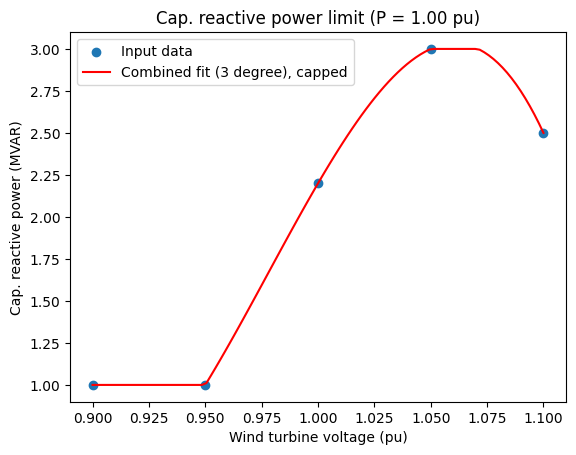

In [26]:
plt.scatter(x_values, y_values, label="Input data")
plt.plot(x, combined_fit_capped(x), color='r', label=f"Combined fit ({degree} degree), capped")
plt.title("Cap. reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine voltage (pu)")
plt.ylabel("Cap. reactive power (MVAR)")
plt.legend()
plt.show()

This is probably as good as it can get with no additional data, or specific knowledge of the wind turbine's converter.

## Nearest neighbor

The nearest neighbor interpolation may seem crude compared to the other methods but it's very efficient, especially with large amounts of data. I wouldn't use it in the current context because it would lead to simulation instability; a slight change in voltage would drastically impact reactive power limits, which in turns change the voltage, which change the limit, etc... This is neither realistic nor practical.

That's just one example though, NN absolutely has a place amongst useful interpolation methods.

> I should give some good application examples.

In [31]:
from scipy.interpolate import interp1d

In [32]:
nn_fit = interp1d(x_values, y_values, kind='nearest')

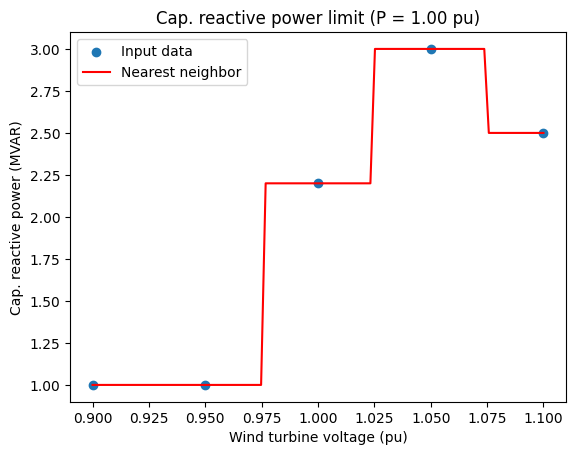

In [34]:
plt.scatter(x_values, y_values, label="Input data")
plt.plot(x, nn_fit(x), color='r', label="Nearest neighbor")
plt.title("Cap. reactive power limit (P = 1.00 pu)")
plt.xlabel("Wind turbine voltage (pu)")
plt.ylabel("Cap. reactive power (MVAR)")
plt.legend()
plt.show()

## Machine learning

Gradient boosting regression is a form of machine learning; it's a powerful technique that combines the predictions of multiple simple models to create a strong predictor, learning from mistakes at each step to make accurate predictions for new data.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
x_values_reshaped = x_values.values.reshape(-1, 1)